# Importando Bibliotecas

In [100]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import itertools

from scipy.stats import normaltest

import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from mlxtend.feature_selection import SequentialFeatureSelector

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

import shap

import warnings
warnings.filterwarnings('ignore')

# Funções

In [2]:
def normal_test(array, alpha=0.05):
    p = normaltest(array).pvalue
    if p < alpha:
        print(f'Rejeita H0. A distribuição NÃO está normalmente distribuída')
    else:
        print(f'Aceita H0. A distribuição está normalmente distribuída. P-valor = {p} >= {alpha}')

# Lendo os Dados

In [3]:
df = pd.read_csv('../Dados/df_final.csv')
df.head()

,data,vendas,vendas_Outra_Faculdade,vendas_PUCRIO,vendas_UFABC,vendas_UFF,vendas_UFMG,vendas_UFPE,vendas_UFRJ,vendas_UFSC,...,vendas_Outra_Cidade,vendas_Porto_Alegre,vendas_Recife,vendas_Rio_de_Janeiro,vendas_Salvador,vendas_Santo_Andre,vendas_Sao_Carlos,vendas_Sao_Paulo,trend,seasonal
0,2018-01-01,1819.00000,618.00000,100.00000,17.00000,194.00000,34.00000,71.00000,407.00000,23.00000,...,587.00000,11.00000,51.00000,521.00000,25.00000,9.00000,14.00000,187.00000,NaN,-2401.78443
1,2018-02-01,2012.00000,652.00000,98.00000,22.00000,199.00000,34.00000,85.00000,492.00000,28.00000,...,654.00000,11.00000,62.00000,592.00000,23.00000,13.00000,14.00000,205.00000,NaN,-1835.22888
2,2018-03-01,4035.00000,926.00000,229.00000,16.00000,357.00000,46.00000,163.00000,1473.00000,30.00000,...,1103.00000,14.00000,123.00000,1544.00000,22.00000,12.00000,29.00000,282.00000,NaN,935.86834
3,2018-04-01,4305.00000,1204.00000,189.00000,186.00000,512.00000,96.00000,134.00000,1098.00000,151.00000,...,1299.00000,21.00000,105.00000,1300.00000,38.00000,40.00000,27.00000,359.00000,NaN,670.79890
4,2018-05-01,3956.00000,1462.00000,176.00000,130.00000,349.00000,212.00000,158.00000,721.00000,122.00000,...,1250.00000,20.00000,110.00000,1065.00000,41.00000,39.00000,31.00000,300.00000,NaN,267.66001


---
# Time Series

## Prophet

In [4]:
df_prophet = df[['data', 'vendas']]
df_prophet.rename(columns={
    'data': 'ds',
    'vendas': 'y'
}, inplace=True)

In [5]:
df_prophet_treino, df_prophet_teste = train_test_split(df_prophet, train_size=0.75, shuffle=False)

In [6]:
model = Prophet()
model.fit(df_prophet_treino)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Performance

In [7]:
forecast = model.predict(df_prophet_teste)

mse = metrics.mean_squared_error(df_prophet_teste['y'], forecast['yhat'])
rmse = metrics.mean_squared_error(df_prophet_teste['y'], forecast['yhat'], squared=False)
mad = metrics.mean_absolute_error(df_prophet_teste['y'], forecast['yhat'])
mape = metrics.mean_absolute_percentage_error(df_prophet_teste['y'], forecast['yhat'])

print(f'''
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      EQM: 2432332.38
      REQM: 1559.59
      MAD: 1415.49
      MAPE: 13.46%
      


In [8]:
fig = go.Figure(data=[
    go.Scatter(name='Previsto',x=forecast['ds'], y=forecast['yhat'], marker={'color': 'orange'}),
    go.Scatter(name='Real', x=df_prophet_teste['ds'], y=df_prophet_teste['y'], marker={'color': 'gray'})
    ])
fig.update_layout(font=dict(color='black'), title_text='Real vs. Previsto (Prophet)')
fig.show()

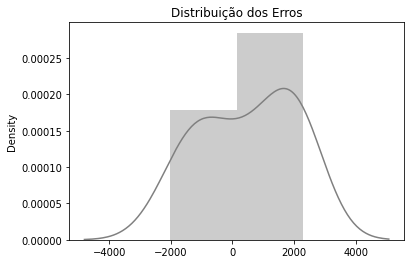

In [97]:
erro_prophet = df_prophet_teste['y'].values - forecast['yhat'].values
sns.distplot(erro_prophet, color='gray')
plt.title('Distribuição dos Erros')
plt.show()

In [10]:
normal_test(erro_prophet)

Aceita H0. A distribuição está normalmente distribuída. P-valor = 0.16786421087169454 >= 0.05


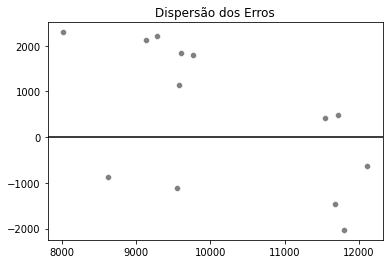

In [98]:
sns.scatterplot(forecast['yhat'].values, erro_prophet, color='gray')
plt.axhline(0, color='black')
plt.title('Dispersão dos Erros')
plt.show()

In [103]:
param_grid = {  
    'changepoint_prior_scale': [0.1, 0.3, 0.5],
    'seasonality_prior_scale': [0.1, 0.5, 1.0],
    'seasonality_mode': ['additive', 'multiplicative']
    }
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
all_params

[{'changepoint_prior_scale': 0.1,
  'seasonality_prior_scale': 0.1,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.1,
  'seasonality_prior_scale': 0.1,
  'seasonality_mode': 'multiplicative'},
 {'changepoint_prior_scale': 0.1,
  'seasonality_prior_scale': 0.5,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.1,
  'seasonality_prior_scale': 0.5,
  'seasonality_mode': 'multiplicative'},
 {'changepoint_prior_scale': 0.1,
  'seasonality_prior_scale': 1.0,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.1,
  'seasonality_prior_scale': 1.0,
  'seasonality_mode': 'multiplicative'},
 {'changepoint_prior_scale': 0.3,
  'seasonality_prior_scale': 0.1,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.3,
  'seasonality_prior_scale': 0.1,
  'seasonality_mode': 'multiplicative'},
 {'changepoint_prior_scale': 0.3,
  'seasonality_prior_scale': 0.5,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.3,
  'seasonality_

In [112]:
mape = []

for params in all_params:
    m = Prophet(**params).fit(df_prophet_treino) 
    df_cv = cross_validation(m, initial='395 days', horizon='240 days', period='240 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mape.append(df_p['mape'].values[0])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 3 forecasts with cutoffs between 2019-03-12 00:00:00 and 2020-07-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001279A4C0BB0>
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 3 forecasts with cutoffs between 2019-03-12 00:00:00 and 2020-07-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001279A2BACD0>
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_s

---
# Regressões

## Feature Engineering

### Criando LAGs

In [12]:
df_r = df.copy().drop(['vendas_Outra_Faculdade', 'vendas_Outra_Cidade', 'trend'], axis=1)
df_r.dropna(axis=0, inplace=True)
df_r.head()

,data,vendas,vendas_PUCRIO,vendas_UFABC,vendas_UFF,vendas_UFMG,vendas_UFPE,vendas_UFRJ,vendas_UFSC,vendas_UNICAMP,...,vendas_Natal,vendas_Niteroi,vendas_Porto_Alegre,vendas_Recife,vendas_Rio_de_Janeiro,vendas_Salvador,vendas_Santo_Andre,vendas_Sao_Carlos,vendas_Sao_Paulo,seasonal
0,2018-01-01,1819.00000,100.00000,17.00000,194.00000,34.00000,71.00000,407.00000,23.00000,200.00000,...,3.00000,79.00000,11.00000,51.00000,521.00000,25.00000,9.00000,14.00000,187.00000,-2401.78443
1,2018-02-01,2012.00000,98.00000,22.00000,199.00000,34.00000,85.00000,492.00000,28.00000,219.00000,...,2.00000,81.00000,11.00000,62.00000,592.00000,23.00000,13.00000,14.00000,205.00000,-1835.22888
2,2018-03-01,4035.00000,229.00000,16.00000,357.00000,46.00000,163.00000,1473.00000,30.00000,577.00000,...,9.00000,171.00000,14.00000,123.00000,1544.00000,22.00000,12.00000,29.00000,282.00000,935.86834
3,2018-04-01,4305.00000,189.00000,186.00000,512.00000,96.00000,134.00000,1098.00000,151.00000,434.00000,...,4.00000,232.00000,21.00000,105.00000,1300.00000,38.00000,40.00000,27.00000,359.00000,670.79890
4,2018-05-01,3956.00000,176.00000,130.00000,349.00000,212.00000,158.00000,721.00000,122.00000,376.00000,...,8.00000,155.00000,20.00000,110.00000,1065.00000,41.00000,39.00000,31.00000,300.00000,267.66001


In [13]:
lag_columns = ['vendas_PUCRIO', 'vendas_UFABC', 'vendas_UFF', 'vendas_UFMG', 'vendas_UFPE', 'vendas_UFRJ', 'vendas_UFSC', 'vendas_UNICAMP', 'vendas_USP', 'vendas_UTFPR', 'vendas_Belo_Horizonte',
       'vendas_Brasilia', 'vendas_Campinas', 'vendas_Campo_Grande',
       'vendas_Curitiba', 'vendas_Florianopolis', 'vendas_Fortaleza',
       'vendas_Goiania', 'vendas_Joinville', 'vendas_Juiz_de_Fora',
       'vendas_Manaus', 'vendas_Natal', 'vendas_Niteroi',
       'vendas_Porto_Alegre', 'vendas_Recife', 'vendas_Rio_de_Janeiro',
       'vendas_Salvador', 'vendas_Santo_Andre', 'vendas_Sao_Carlos',
       'vendas_Sao_Paulo']

In [14]:
for column in lag_columns:
    for lag in range(1, 4):
        novo_nome = f'{column}_LAG_{lag}'
        df_r[novo_nome] = df_r[column].shift(periods=lag, fill_value=0)

In [15]:
lag_columns_2 = ['vendas', 'seasonal']

In [16]:
for column in lag_columns_2:
    for lag in range(3, 13):
        novo_nome = f'{column}_LAG_{lag}'
        df_r[novo_nome] = df_r[column].shift(periods=lag, fill_value=0)

In [17]:
df_r.drop(lag_columns, axis=1, inplace=True)
df_r.drop('seasonal', axis=1, inplace=True)
df_r.head()

,data,vendas,vendas_PUCRIO_LAG_1,vendas_PUCRIO_LAG_2,vendas_PUCRIO_LAG_3,vendas_UFABC_LAG_1,vendas_UFABC_LAG_2,vendas_UFABC_LAG_3,vendas_UFF_LAG_1,vendas_UFF_LAG_2,...,seasonal_LAG_3,seasonal_LAG_4,seasonal_LAG_5,seasonal_LAG_6,seasonal_LAG_7,seasonal_LAG_8,seasonal_LAG_9,seasonal_LAG_10,seasonal_LAG_11,seasonal_LAG_12
0,2018-01-01,1819.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,2018-02-01,2012.00000,100.00000,0.00000,0.00000,17.00000,0.00000,0.00000,194.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,2018-03-01,4035.00000,98.00000,100.00000,0.00000,22.00000,17.00000,0.00000,199.00000,194.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,2018-04-01,4305.00000,229.00000,98.00000,100.00000,16.00000,22.00000,17.00000,357.00000,199.00000,...,-2401.78443,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,2018-05-01,3956.00000,189.00000,229.00000,98.00000,186.00000,16.00000,22.00000,512.00000,357.00000,...,-1835.22888,-2401.78443,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


### Criando Dummies - Mês

In [18]:
df_r['mes'] = pd.to_datetime(df_r['data']).dt.month_name()
df_r.head()

,data,vendas,vendas_PUCRIO_LAG_1,vendas_PUCRIO_LAG_2,vendas_PUCRIO_LAG_3,vendas_UFABC_LAG_1,vendas_UFABC_LAG_2,vendas_UFABC_LAG_3,vendas_UFF_LAG_1,vendas_UFF_LAG_2,...,seasonal_LAG_4,seasonal_LAG_5,seasonal_LAG_6,seasonal_LAG_7,seasonal_LAG_8,seasonal_LAG_9,seasonal_LAG_10,seasonal_LAG_11,seasonal_LAG_12,mes
0,2018-01-01,1819.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,January
1,2018-02-01,2012.00000,100.00000,0.00000,0.00000,17.00000,0.00000,0.00000,194.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,February
2,2018-03-01,4035.00000,98.00000,100.00000,0.00000,22.00000,17.00000,0.00000,199.00000,194.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,March
3,2018-04-01,4305.00000,229.00000,98.00000,100.00000,16.00000,22.00000,17.00000,357.00000,199.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,April
4,2018-05-01,3956.00000,189.00000,229.00000,98.00000,186.00000,16.00000,22.00000,512.00000,357.00000,...,-2401.78443,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,May


In [19]:
df_r = pd.get_dummies(df_r, columns=['mes'])
df_r.head()

,data,vendas,vendas_PUCRIO_LAG_1,vendas_PUCRIO_LAG_2,vendas_PUCRIO_LAG_3,vendas_UFABC_LAG_1,vendas_UFABC_LAG_2,vendas_UFABC_LAG_3,vendas_UFF_LAG_1,vendas_UFF_LAG_2,...,mes_December,mes_February,mes_January,mes_July,mes_June,mes_March,mes_May,mes_November,mes_October,mes_September
0,2018-01-01,1819.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0,0,1,0,0,0,0,0,0,0
1,2018-02-01,2012.00000,100.00000,0.00000,0.00000,17.00000,0.00000,0.00000,194.00000,0.00000,...,0,1,0,0,0,0,0,0,0,0
2,2018-03-01,4035.00000,98.00000,100.00000,0.00000,22.00000,17.00000,0.00000,199.00000,194.00000,...,0,0,0,0,0,1,0,0,0,0
3,2018-04-01,4305.00000,229.00000,98.00000,100.00000,16.00000,22.00000,17.00000,357.00000,199.00000,...,0,0,0,0,0,0,0,0,0,0
4,2018-05-01,3956.00000,189.00000,229.00000,98.00000,186.00000,16.00000,22.00000,512.00000,357.00000,...,0,0,0,0,0,0,1,0,0,0


### Divisão entre Treino e Teste

In [20]:
df_r_treino, df_r_teste = train_test_split(df_r, train_size=0.75, shuffle=False)

In [21]:
X_r = df_r.drop(['data', 'vendas'], axis=1)
y_r = df_r['vendas']

In [22]:
X_r_treino, X_r_teste, y_r_treino, y_r_teste = train_test_split(X_r, y_r, train_size=0.75, shuffle=False)

In [23]:
tss = TimeSeriesSplit(n_splits=5)

## Modelos

In [24]:
modelos = [LinearRegression(), Ridge(), Lasso(), DecisionTreeRegressor(), SVR(), AdaBoostRegressor(), ExtraTreesRegressor(), GradientBoostingRegressor(), RandomForestRegressor(), HistGradientBoostingRegressor(), LGBMRegressor(), CatBoostRegressor(verbose=False)]

In [25]:
modelos_score = []

for modelo in modelos:
    pipe = Pipeline(steps=[
    ('preprocessor', StandardScaler()),
    ('model', modelo)
    ])
    cv = cross_val_score(pipe, X_r_treino, y_r_treino, cv=tss, scoring='neg_mean_absolute_percentage_error')
    modelos_score.append({'modelo': modelo, 'mape': cv.mean()*(-100), 'std': cv.std()*(100)})

In [26]:
modelos_score = pd.DataFrame(modelos_score)
modelos_score.sort_values(by='mape', ascending=True, inplace=True)
modelos_score

,modelo,mape,std
5,AdaBoostRegressor(),19.66089,4.31791
8,RandomForestRegressor(),21.10749,5.38970
7,GradientBoostingRegressor(),22.06537,7.38769
3,DecisionTreeRegressor(),22.21975,9.10903
6,ExtraTreesRegressor(),22.45802,7.37844
1,Ridge(),23.14110,9.24965
11,<catboost.core.CatBoostRegressor object at 0x0...,23.72045,7.00143
0,LinearRegression(),24.34091,8.90464
2,Lasso(),29.57274,14.40513
9,HistGradientBoostingRegressor(),31.21862,6.02576


# Extra Trees Regressor

In [27]:
pipe_et = Pipeline(steps=[
    ('preprocessor', StandardScaler()),
    ('model', ExtraTreesRegressor())
])

In [28]:
pipe_et.fit(X_r_treino, y_r_treino)

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('model', ExtraTreesRegressor())])

In [29]:
pred_teste_et = pipe_et.predict(X_r_teste)

mse = metrics.mean_squared_error(y_r_teste, pred_teste_et)
rmse = metrics.mean_squared_error(y_r_teste, pred_teste_et, squared=False)
mad = metrics.mean_absolute_error(y_r_teste, pred_teste_et)
mape = metrics.mean_absolute_percentage_error(y_r_teste, pred_teste_et)

print(f'''
      ExtraTrees Regression Standard - Teste
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      ExtraTrees Regression Standard - Teste
      EQM: 5090891.03
      REQM: 2256.3
      MAD: 1946.2
      MAPE: 17.39%
      


In [30]:
fig = go.Figure(data=[
    go.Scatter(name='Previsto', x=df_r_teste['data'], y=pred_teste_et, marker={'color': 'orange'}),
    go.Scatter(name='Real', x=df_r_teste['data'], y=y_r_teste, marker={'color': 'gray'})
    ])
fig.update_layout(font=dict(color='black'), title_text='Real vs. Previsto (ExtraTrees Regression)')
fig.show()

### Feature Selection

In [31]:
bfs = SequentialFeatureSelector(pipe_et, k_features='best', scoring='r2', cv=tss, forward=False)
bfs.fit(X_r_treino, y_r_treino)

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                          estimator=Pipeline(steps=[('preprocessor',
                                                     StandardScaler()),
                                                    ('model',
                                                     ExtraTreesRegressor())]),
                          forward=False, k_features='best', scoring='r2')

In [32]:
bfs_features = list(bfs.k_feature_names_)
bfs_features

['vendas_PUCRIO_LAG_1',
 'vendas_UFABC_LAG_1',
 'vendas_Brasilia_LAG_1',
 'vendas_LAG_8',
 'vendas_LAG_12',
 'seasonal_LAG_11',
 'seasonal_LAG_12',
 'mes_January']

In [33]:
cv_all = cross_val_score(pipe_et, X_r_treino, y_r_treino, cv=tss, scoring='neg_mean_absolute_percentage_error')
print(f'''Resultado por Cross-Validation usando todas as features: {cv_all.mean()*(-100)} +/- {cv_all.std()*(100)}''')

Resultado por Cross-Validation usando todas as features: 21.470753784321655 +/- 7.833190156752891


In [34]:
X_r_treino_bfs = X_r_treino.loc[:,bfs_features]
cv_bfs = cross_val_score(pipe_et, X_r_treino_bfs, y_r_treino, cv=tss, scoring='neg_mean_absolute_percentage_error')
print(f'''Resultado por Cross-Validation usando as "melhores" features: {cv_bfs.mean()*(-100)} +/- {cv_bfs.std()*(100)}''')

Resultado por Cross-Validation usando todas as features: 17.060474151561117 +/- 2.847877565513427


### Tuning

In [55]:
params = {"model__max_depth": [None, 4, 8, 12, 16, 20],
          "model__min_samples_split": np.arange(2, 11),
          "model__min_samples_leaf": np.arange(1, 11),
          "model__n_estimators": np.arange(100,650,50)}
params

{'model__max_depth': [None, 4, 8, 12, 16, 20],
 'model__min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'model__min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'model__n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600])}

In [56]:
grid = GridSearchCV(pipe_et, param_grid=params, scoring='neg_mean_absolute_percentage_error', cv=tss, n_jobs=-1, verbose=1)
grid.fit(X_r_treino_bfs, y_r_treino)

Fitting 5 folds for each of 5940 candidates, totalling 29700 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessor', StandardScaler()),
                                       ('model', ExtraTreesRegressor())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 4, 8, 12, 16, 20],
                         'model__min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'model__min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'model__n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600])},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [57]:
grid.best_params_

{'model__max_depth': 12,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 150}

In [83]:
pipe_et_tuned = Pipeline(steps=[
    ('preprocessor', StandardScaler()),
    ('model', ExtraTreesRegressor(max_depth=grid.best_params_['model__max_depth'],
                                  min_samples_leaf=grid.best_params_['model__min_samples_leaf'],
                                  min_samples_split=grid.best_params_['model__min_samples_split'],
                                  n_estimators=grid.best_params_['model__n_estimators']))
])

In [84]:
cv_bfs_tuned = cross_val_score(pipe_et_tuned, X_r_treino_bfs, y_r_treino, cv=tss, scoring='neg_mean_absolute_percentage_error')
print(f'''Resultado por Cross-Validation usando as "melhores" features e o Hiperparâmetros: {cv_bfs_tuned.mean()*(-100)} +/- {cv_bfs_tuned.std()*(100)}''')

Resultado por Cross-Validation usando as "melhores" features e o Hiperparâmetros: 17.188479979841723 +/- 2.4681012595444805


In [85]:
pipe_et_tuned.fit(X_r_treino_bfs, y_r_treino)

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('model', ExtraTreesRegressor(max_depth=12, n_estimators=150))])

In [86]:
X_r_teste_bfs = X_r_teste.loc[:,bfs_features]
pred_teste_et_tuned = pipe_et_tuned.predict(X_r_teste_bfs)

mse = metrics.mean_squared_error(y_r_teste, pred_teste_et_tuned)
rmse = metrics.mean_squared_error(y_r_teste, pred_teste_et_tuned, squared=False)
mad = metrics.mean_absolute_error(y_r_teste, pred_teste_et_tuned)
mape = metrics.mean_absolute_percentage_error(y_r_teste, pred_teste_et_tuned)

print(f'''
      ExtraTrees Regression Standard - Teste
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      ExtraTrees Regression Standard - Teste
      EQM: 6694007.71
      REQM: 2587.28
      MAD: 2275.73
      MAPE: 20.92%
      


In [87]:
fig = go.Figure(data=[
    go.Scatter(name='Previsto', x=df_r_teste['data'], y=pred_teste_et_tuned, marker={'color': 'orange'}),
    go.Scatter(name='Real', x=df_r_teste['data'], y=y_r_teste, marker={'color': 'gray'})
    ])
fig.update_layout(font=dict(color='black'), title_text='Real vs. Previsto (ExtraTrees Regression)')
fig.show()

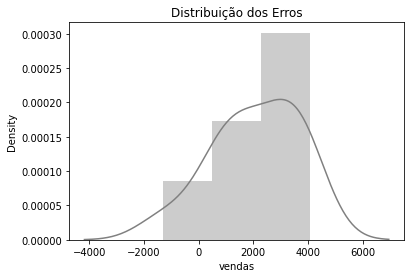

In [92]:
erro_et = y_r_teste - pred_teste_et_tuned
sns.distplot(erro_et, color='gray')
plt.title('Distribuição dos Erros')
plt.show()

In [89]:
normal_test(erro_et)

Aceita H0. A distribuição está normalmente distribuída. P-valor = 0.5851041549943073 >= 0.05


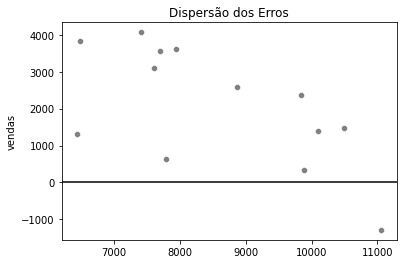

In [93]:
sns.scatterplot(pred_teste_et_tuned, erro_et, color='gray')
plt.axhline(0, color='black')
plt.title('Dispersão dos Erros')
plt.show()

# Plot dos Três Métodos

In [91]:
fig = go.Figure(data=[
    go.Scatter(name='Previsto Prophet',x=forecast['ds'], y=forecast['yhat'], marker={'color': 'green'}),
    go.Scatter(name='Previsto ExtraTrees', x=df_r_teste['data'], y=pred_teste_et_tuned, marker={'color': 'orange'}),
    go.Scatter(name='Real', x=df_r_teste['data'], y=y_r_teste, marker={'color': 'gray'})
    ])
fig.update_layout(font=dict(color='black'), title_text='Real vs. Previsto')
fig.show()

# Interpretação

### Feature Importance

In [70]:
feat_importances = pd.Series(pipe_et_tuned['model'].feature_importances_, index=X_r_treino_bfs.columns)

<AxesSubplot:title={'center':'Feature Importances'}>

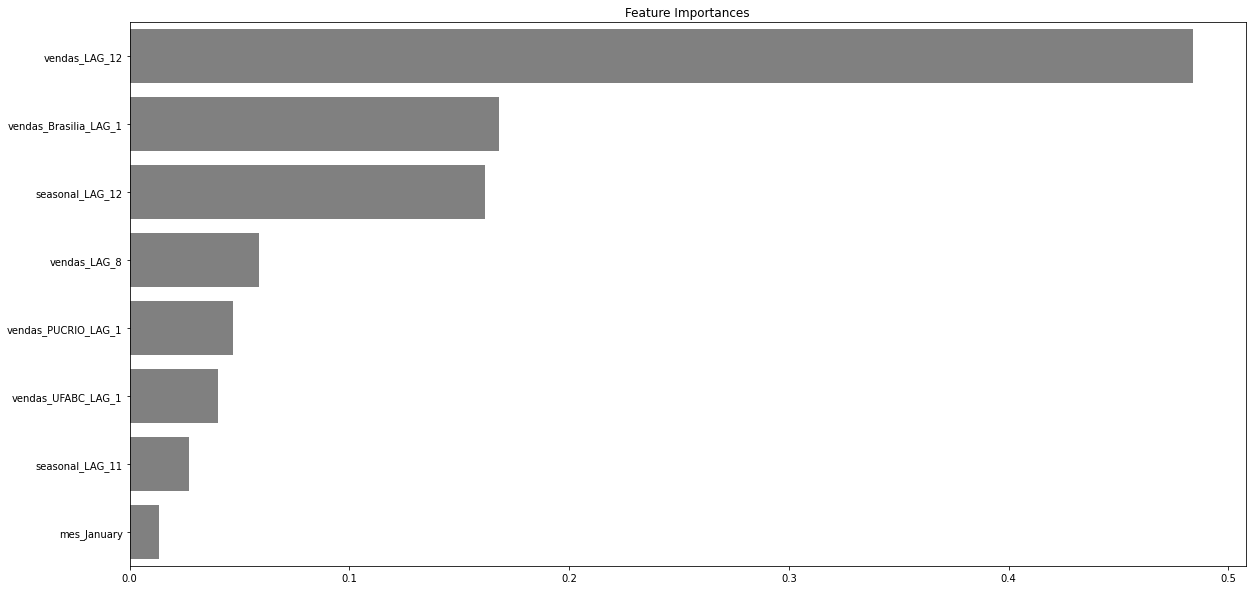

In [94]:
plt.figure(figsize=(20,10))
plt.title('Feature Importances')
sns.barplot(x=feat_importances.nlargest(10), y=feat_importances.nlargest(10).index, orient='h', color='gray')

### Shap

In [72]:
shap.initjs()

In [73]:
explainer = shap.TreeExplainer(pipe_et_tuned['model'])
shap_values = explainer.shap_values(X_r_treino_bfs)

##### Summary Plot

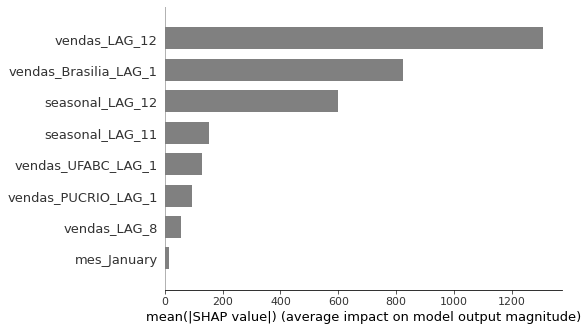

In [95]:
shap.summary_plot(shap_values, X_r_treino_bfs, plot_type='bar', color='gray')

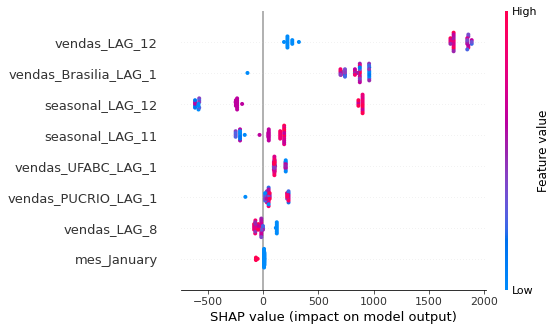

In [75]:
shap.summary_plot(shap_values, X_r_treino_bfs)

##### Dependence Plot

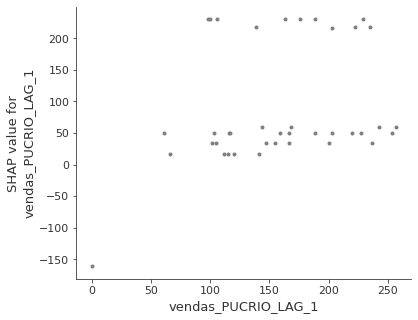

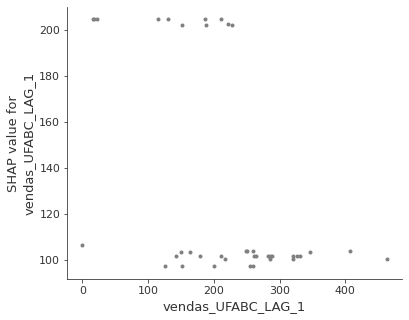

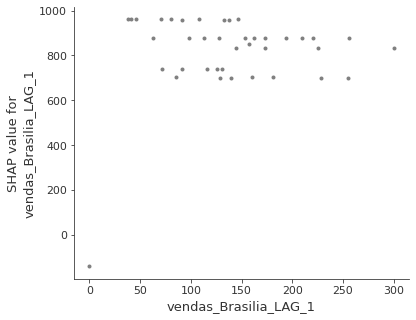

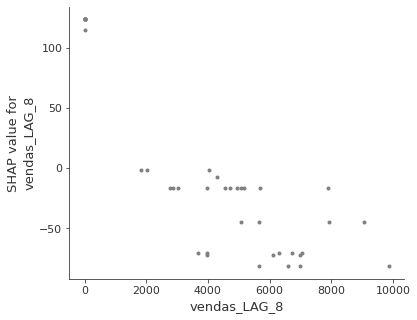

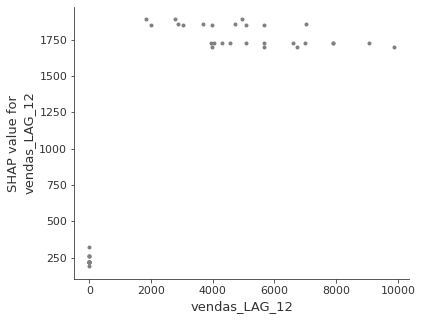

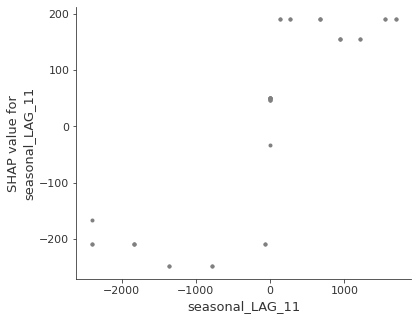

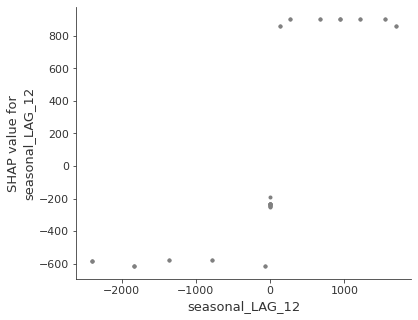

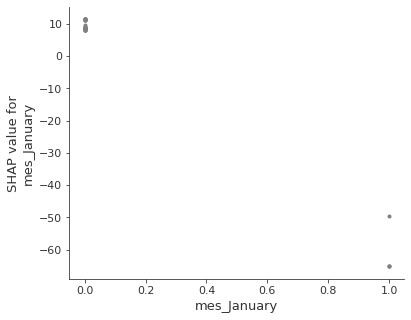

In [96]:
for column in X_r_treino_bfs.columns:
  shap.dependence_plot(column, shap_values, X_r_treino_bfs, interaction_index=None, color='gray')

##### Force Plot

In [78]:
shap.force_plot(explainer.expected_value, shap_values[38], X_r_treino_bfs.iloc[38,:])